# MultiviewSMPLifyX Inference Notebook

This notebook is a cell-by-cell version of `main.py` for interactive inference.

Current scope:
- Load config and dataset
- Build SMPL model + priors
- Build multiview cameras and keypoints
- Run fitting and export mesh/params

Later we can add overlay visualization cells for projected mesh on input images.

In [1]:
import os
import os.path as osp
import sys
import time
import yaml

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import smplx

from utils import JointMapper
from cmd_parser import parse_config
from data_parser import create_dataset
from fit_single_frame import fit_single_frame
from camera import create_camera
from prior import create_prior

torch.backends.cudnn.enabled = False

In [2]:
# Runtime paths (edit these as needed)
CONFIG_PATH = 'cfg_files/fit_smpl.yaml'
DATA_FOLDER = './dataset_example/image_data/rp_dennis_posed_004'
OUTPUT_FOLDER = './dataset_example/mesh_data/rp_dennis_posed_004/notebook'

# Parse the same config flow used by main.py
sys.argv = [
    'notebook',
    '--config', CONFIG_PATH,
    '--data_folder', DATA_FOLDER,
    '--output_folder', OUTPUT_FOLDER,
]

args = parse_config()
print('Loaded config with keys:', len(args))
print('Data folder:', args['data_folder'])
print('Output folder:', args['output_folder'])

Loaded config with keys: 70
Data folder: ./dataset_example/image_data/rp_dennis_posed_004
Output folder: ./dataset_example/mesh_data/rp_dennis_posed_004/notebook


In [3]:
# Step 1: output folder + dataset
output_folder = args.pop('output_folder')
output_folder = osp.expandvars(output_folder)
os.makedirs(output_folder, exist_ok=True)

conf_fn = osp.join(output_folder, 'conf.yaml')
with open(conf_fn, 'w') as conf_file:
    yaml.dump(args, conf_file)
print(f'Config saved to {conf_fn}')

float_dtype = args.get('float_dtype', 'float32')
if float_dtype == 'float64':
    dtype = torch.float64
elif float_dtype == 'float32':
    dtype = torch.float32
else:
    raise ValueError(f"Unknown float type {float_dtype}")

use_cuda = args.get('use_cuda', True)
if use_cuda and not torch.cuda.is_available():
    raise RuntimeError('CUDA is not available. Set use_cuda=False in config or start a CUDA runtime.')

img_folder = args.pop('img_folder', 'images')
dataset_obj = create_dataset(img_folder=img_folder, **args)

start = time.time()

input_gender = args.pop('gender', 'neutral')
gender_lbl_type = args.pop('gender_lbl_type', 'none')
max_persons = args.pop('max_persons', -1)

print('Views in dataset:', len(dataset_obj))
print('Gender mode:', input_gender)

Config saved to ./dataset_example/mesh_data/rp_dennis_posed_004/notebook/conf.yaml
Views in dataset: 360
Gender mode: neutral


In [4]:
# Step 2: body models + priors
joint_mapper = JointMapper(dataset_obj.get_model2data())

model_params = dict(
    model_path=args.get('model_folder'),
    joint_mapper=joint_mapper,
    create_global_orient=True,
    create_body_pose=not args.get('use_vposer'),
    create_betas=True,
    create_left_hand_pose=True,
    create_right_hand_pose=True,
    create_expression=True,
    create_jaw_pose=True,
    create_leye_pose=True,
    create_reye_pose=True,
    create_transl=False,
    dtype=dtype,
    **args,
)

male_model = smplx.create(gender='male', **model_params)
neutral_model = None
if args.get('model_type') != 'smplh':
    neutral_model = smplx.create(gender='neutral', **model_params)
female_model = smplx.create(gender='female', **model_params)

use_hands = args.get('use_hands', True)
use_face = args.get('use_face', True)

body_pose_prior = create_prior(prior_type=args.get('body_prior_type'), dtype=dtype, **args)
shape_prior = create_prior(prior_type=args.get('shape_prior_type', 'l2'), dtype=dtype, **args)
angle_prior = create_prior(prior_type='angle', dtype=dtype)

jaw_prior, expr_prior = None, None
if use_face:
    jaw_prior = create_prior(prior_type=args.get('jaw_prior_type'), dtype=dtype, **args)
    expr_prior = create_prior(prior_type=args.get('expr_prior_type', 'l2'), dtype=dtype, **args)

left_hand_prior, right_hand_prior = None, None
if use_hands:
    lhand_args = args.copy()
    lhand_args['num_gaussians'] = args.get('num_pca_comps')
    left_hand_prior = create_prior(prior_type=args.get('left_hand_prior_type'), dtype=dtype, use_left_hand=True, **lhand_args)

    rhand_args = args.copy()
    rhand_args['num_gaussians'] = args.get('num_pca_comps')
    right_hand_prior = create_prior(prior_type=args.get('right_hand_prior_type'), dtype=dtype, use_right_hand=True, **rhand_args)

print('Model and priors initialized.')

Model and priors initialized.


In [8]:
# Step 3: device transfer + multiview camera/keypoint assembly (use exactly 4 views)
if use_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

female_model = female_model.to(device=device)
male_model = male_model.to(device=device)
if neutral_model is not None:
    neutral_model = neutral_model.to(device=device)

body_pose_prior = body_pose_prior.to(device=device)
shape_prior = shape_prior.to(device=device)
angle_prior = angle_prior.to(device=device)
if use_face:
    expr_prior = expr_prior.to(device=device)
    jaw_prior = jaw_prior.to(device=device)
if use_hands:
    left_hand_prior = left_hand_prior.to(device=device)
    right_hand_prior = right_hand_prior.to(device=device)

joint_weights = dataset_obj.get_joint_weights().to(device=device, dtype=dtype)
joint_weights.unsqueeze_(dim=0)

img_list, keypoints_list, camera_list = [], [], []
selected_image_ids = []

view_num = len(dataset_obj)
if view_num < 4:
    raise ValueError(f'Need at least 4 images/views, but found {view_num}')

# selected_indices = np.linspace(0, view_num - 1, num=4, dtype=int).tolist()
selected_indices = [0, 50, 100, 150]
selected_indices = sorted(set(selected_indices))

for idx in selected_indices:
    data = dataset_obj[idx]

    img = data['img']
    keypoints = data['keypoints'][[0]]

    focal_length = args.get('focal_length')
    camera = create_camera(
        focal_length_x=focal_length,
        focal_length_y=focal_length,
        dtype=dtype,
        **args,
    )

    cam_R = data['cam_R']
    cam_t = data['cam_t']
    cam_fx = data['cam_fx']
    cam_fy = data['cam_fy']
    cam_cx = data['cam_cx']
    cam_cy = data['cam_cy']

    camera.focal_length_x = torch.full([1], cam_fx, dtype=dtype)
    camera.focal_length_y = torch.full([1], cam_fy, dtype=dtype)
    camera.center = torch.tensor([cam_cx, cam_cy], dtype=dtype).unsqueeze(0)
    camera.rotation.data = torch.from_numpy(cam_R).unsqueeze(0)
    camera.translation.data = torch.from_numpy(cam_t).unsqueeze(0)
    camera.rotation.requires_grad = False
    camera.translation.requires_grad = False

    if use_cuda and torch.cuda.is_available():
        camera = camera.to(device)

    img_list.append(img)
    keypoints_list.append(keypoints)
    camera_list.append(camera)
    selected_image_ids.append(data['fn'])

    print('Selected:', data['img_path'])

print('Selected 4 image ids:', selected_image_ids)

Selected: ./dataset_example/image_data/rp_dennis_posed_004/color/0000.jpg
Selected: ./dataset_example/image_data/rp_dennis_posed_004/color/0050.jpg
Selected: ./dataset_example/image_data/rp_dennis_posed_004/color/0100.jpg
Selected: ./dataset_example/image_data/rp_dennis_posed_004/color/0150.jpg
Selected 4 image ids: ['0000', '0050', '0100', '0150']


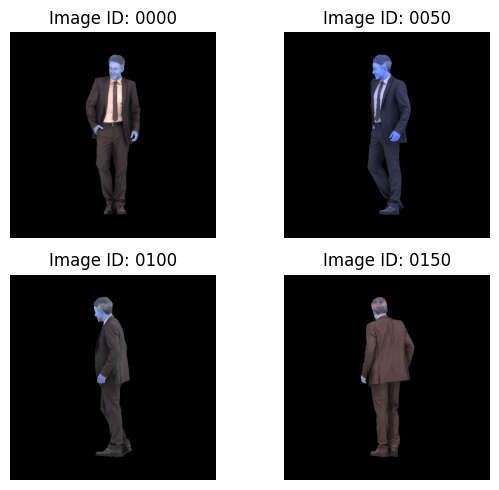

In [11]:
# Step 3.1: visualize selected 4 views in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(6,5))
axes = axes.ravel()

for i, (img, img_id) in enumerate(zip(img_list, selected_image_ids)):
    axes[i].imshow(img)
    axes[i].set_title(f'Image ID: {img_id}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

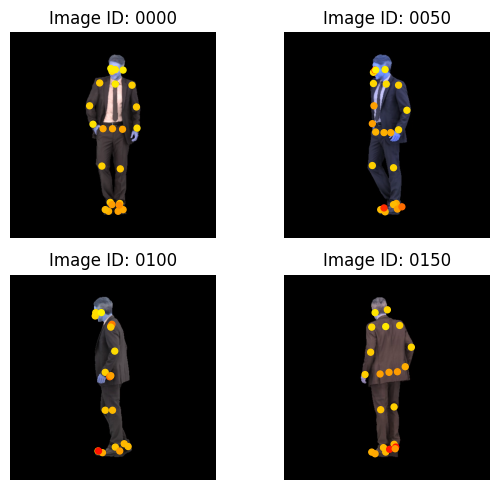

In [12]:
# Step 3.2: render keypoints on top of corresponding selected images (matched by image id)
id_to_img = {img_id: img for img_id, img in zip(selected_image_ids, img_list)}
id_to_kps = {img_id: kps for img_id, kps in zip(selected_image_ids, keypoints_list)}

fig, axes = plt.subplots(2, 2, figsize=(6, 5))
axes = axes.ravel()

for i, img_id in enumerate(selected_image_ids):
    img = id_to_img[img_id]
    kps = id_to_kps[img_id][0]  # shape: (J, 3) -> x, y, conf

    axes[i].imshow(img)

    valid = kps[:, 2] > 0.05
    axes[i].scatter(
        kps[valid, 0],
        kps[valid, 1],
        c=kps[valid, 2],
        s=18,
        cmap='autumn',
        vmin=0.0,
        vmax=1.0,
    )

    axes[i].set_title(f'Image ID: {img_id}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Step 4: run fitting and save outputs
curr_result_fn = osp.join(output_folder, 'smpl_param.pkl')
curr_mesh_fn = osp.join(output_folder, 'smpl_mesh.obj')

gender = input_gender
if gender == 'neutral':
    if neutral_model is None:
        raise RuntimeError('Neutral model is not available for model_type=smplh')
    body_model = neutral_model
elif gender == 'female':
    body_model = female_model
elif gender == 'male':
    body_model = male_model
else:
    raise ValueError(f'Unknown gender: {gender}')

fit_single_frame(
    img_list,
    keypoints_list,
    body_model=body_model,
    camera_list=camera_list,
    joint_weights=joint_weights,
    dtype=dtype,
    output_folder=output_folder,
    result_fn=curr_result_fn,
    mesh_fn=curr_mesh_fn,
    shape_prior=shape_prior,
    expr_prior=expr_prior,
    body_pose_prior=body_pose_prior,
    left_hand_prior=left_hand_prior,
    right_hand_prior=right_hand_prior,
    jaw_prior=jaw_prior,
    angle_prior=angle_prior,
    **args,
)

elapsed = time.time() - start
print('Done. Result params:', curr_result_fn)
print('Done. Result mesh:', curr_mesh_fn)
print('Elapsed:', time.strftime('%Hh %Mm %Ss', time.gmtime(elapsed)))

Found Trained Model: ./vposer/models/snapshots/TR00_E096.pt


/home/aari/projects/MultiviewSMPLifyX/vposer/model_loader.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vposer_pt.load_state_dict(torch.load(trained_model_fname, map_

Stage 000 done after 15.1904 seconds


                                                  
Orientation:   0%|          | 0/1 [00:28<?, ?it/s]  

Stage 001 done after 13.0580 seconds


                                                  
Orientation:   0%|          | 0/1 [00:48<?, ?it/s]  

Stage 002 done after 19.5013 seconds


                                                  
Orientation: 100%|██████████| 1/1 [02:16<00:00, 136.11s/it]


Stage 003 done after 87.6493 seconds
Body fitting Orientation 0 done after 136.0766 seconds
Body final loss val = 6249.10938
body_scale = 0.450098
Done. Result params: ./dataset_example/mesh_data/rp_dennis_posed_004/notebook/smpl_param.pkl
Done. Result mesh: ./dataset_example/mesh_data/rp_dennis_posed_004/notebook/smpl_mesh.obj
Elapsed: 00h 04m 26s


## Next (planned)
- Add image display cells for selected multiview inputs.
- Project fitted mesh vertices to each image and render overlay for visual QA.
- Save side-by-side overlay outputs under output folder.

Loaded mesh: verts=6890, faces=13776


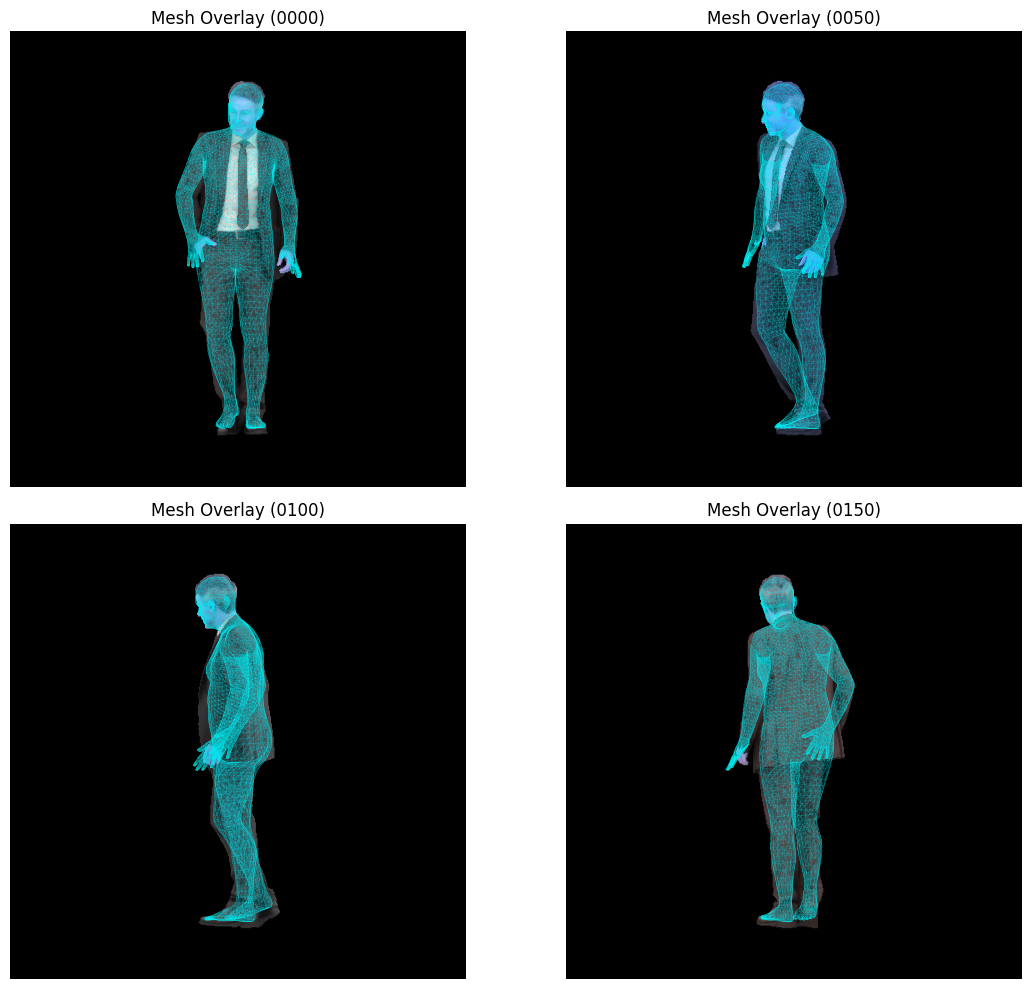

Saved combined mesh overlay: ./dataset_example/mesh_data/rp_dennis_posed_004/notebook/overlays/overlay_4views_mesh.png


In [15]:
# Step 5: render projected mesh on all selected images in one 2x2 figure and save one file
from matplotlib.collections import PolyCollection

overlay_folder = osp.join(output_folder, 'overlays')
os.makedirs(overlay_folder, exist_ok=True)

if not osp.exists(curr_mesh_fn):
    raise FileNotFoundError(f'Mesh file not found: {curr_mesh_fn}')

def load_obj_mesh(obj_path):
    verts = []
    faces = []
    with open(obj_path, 'r') as f:
        for line in f:
            if line.startswith('v '):
                _, x, y, z = line.strip().split()[:4]
                verts.append([float(x), float(y), float(z)])
            elif line.startswith('f '):
                toks = line.strip().split()[1:]
                idx = [int(t.split('/')[0]) - 1 for t in toks]
                if len(idx) == 3:
                    faces.append(idx)
                elif len(idx) > 3:
                    for i in range(1, len(idx) - 1):
                        faces.append([idx[0], idx[i], idx[i + 1]])

    if len(verts) == 0 or len(faces) == 0:
        raise ValueError(f'Invalid mesh, verts={len(verts)} faces={len(faces)}: {obj_path}')
    return np.asarray(verts, dtype=np.float32), np.asarray(faces, dtype=np.int32)

def project_points(verts_world, cam):
    R = cam.rotation.detach().cpu().numpy()[0]
    t = cam.translation.detach().cpu().numpy()[0]
    fx = float(cam.focal_length_x.detach().cpu().numpy()[0])
    fy = float(cam.focal_length_y.detach().cpu().numpy()[0])
    cx = float(cam.center.detach().cpu().numpy()[0, 0])
    cy = float(cam.center.detach().cpu().numpy()[0, 1])

    pts_cam = verts_world @ R.T + t[None, :]
    z = pts_cam[:, 2]
    valid = z > 1e-6

    u = fx * (pts_cam[:, 0] / np.clip(z, 1e-6, None)) + cx
    v = fy * (pts_cam[:, 1] / np.clip(z, 1e-6, None)) + cy
    return np.stack([u, v], axis=1), valid, z

verts_world, faces = load_obj_mesh(curr_mesh_fn)
print(f'Loaded mesh: verts={verts_world.shape[0]}, faces={faces.shape[0]}')

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (img, cam, img_id) in enumerate(zip(img_list, camera_list, selected_image_ids)):
    uv, valid, z = project_points(verts_world, cam)

    face_valid = valid[faces].all(axis=1)
    face_depth = z[faces].mean(axis=1)
    face_valid &= face_depth > 1e-6

    draw_faces = faces[face_valid]
    draw_depth = face_depth[face_valid]

    if draw_faces.shape[0] > 12000:
        keep = np.random.choice(draw_faces.shape[0], size=12000, replace=False)
        draw_faces = draw_faces[keep]
        draw_depth = draw_depth[keep]

    order = np.argsort(draw_depth)[::-1]
    draw_faces = draw_faces[order]

    tri_2d = uv[draw_faces]

    ax = axes[i]
    ax.imshow(img)

    polys = PolyCollection(
        tri_2d,
        facecolors=(0.1, 0.8, 0.9, 0.08),
        edgecolors=(0.0, 1.0, 1.0, 0.22),
        linewidths=0.25
    )
    ax.add_collection(polys)
    ax.set_title(f'Mesh Overlay ({img_id})')
    ax.axis('off')

# Hide unused axes if any
for j in range(len(img_list), 4):
    axes[j].axis('off')

combined_fn = osp.join(overlay_folder, 'overlay_4views_mesh.png')
plt.tight_layout()
plt.savefig(combined_fn, dpi=220, bbox_inches='tight')
plt.show()
print('Saved combined mesh overlay:', combined_fn)